In [2]:
from math import ceil
import os
from datetime import datetime
import psycopg2 as db
from cjio import cityjson
import numpy as np

from modulaire.db_rw_operations import (bbox_helpers_db, remove_rows_from_db,
                                        retrieve_heights,
                                        subset_table_from_cm_bbox)
from modulaire.ids_and_labels import get_cat_and_class_from_building
from modulaire.raster_preparation import init_coord_matrix, pad_crop_matrix

import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [3]:
path = "../original_ds/converted_to_cityjson/1011-43.json"

args = {"db_name":"regbl", "db_username":"postgres", "db_password":"$asd$"}

print(f"Starting file {os.path.split(path)[-1]} - {datetime.now()}")
# Retrieve the citymodel
cm = cityjson.load(path)
buildings = cm.get_cityobjects(type=["Building", "BuildingPart"])
# Keep a set of building installation
building_installation_list = set(
    cm.get_cityobjects(type=["BuildingInstallation"]).keys())
# DB connection
connection_string = "dbname='" + args['db_name'] + "' user='" + args['db_username'] + "' host='localhost' password='" + args['db_password'] + \
    "'" if args['db_password'] is not None else "dbname='" + args['db_name'] + \
    "' user='" + args.db_username + "' host='localhost'"
conn = db.connect(connection_string)
cur = conn.cursor()

Starting file 1011-43.json - 2022-07-23 08:41:19.260361


In [4]:
b = buildings["_F87D6ADD-0D0F-49C1-99B7-0E84DFA280DB"] # Cas simple

Rajoute les géométries dans la DB

In [5]:
get_cat_and_class_from_building(b, cur, conn)

{'catClass': [1020, 1122], 'egid': [481611]}

In [7]:
# Compute the coordinates
x_diff, x_med, y_diff, y_med = bbox_helpers_db(cur)

In [ ]:
print(x_diff, x_med, y_diff, y_med)

In [1]:
x_med 

NameError: name 'x_med' is not defined

In [ ]:
int(ceil(x_diff) / 0.5)

In [ ]:
resolution_m = 1

In [ ]:
x_dim = int(ceil(x_diff) / resolution_m)
y_dim = int(ceil(y_diff) / resolution_m)

In [ ]:
print(x_dim, y_dim)

In [ ]:
rast_pts = np.zeros((x_dim, y_dim, 3))

In [ ]:
rast_pts.shape

In [ ]:
for x in range(x_dim):
    for y in range(y_dim):
        x_delta = x - (x_dim-1) / 2
        y_delta = y - (y_dim-1) / 2
        rast_pts[x, y, :] = [x_med + x_delta, y_med + y_delta, 0]

In [ ]:
0 - (24) / 2

In [ ]:
for i in rast_pts:
    for j in i:
        print(j)

In [ ]:
rast_pts[0,0,0:2]

In [ ]:
" ".join(str(e) for e in rast_pts[0, 0, 0:2])

In [ ]:
def retrieve_heights(coord_matrix, cursor):
    """
    Return a numpy array containing the height
    difference between roof and ground for
    every pixel in the input raster

    :param coord_matrix: A numpy array of shape (xdim, ydim, (x_coord, y_coord, 0))
    :param cursor: A psycopg2 cursor
    """
    height_bsql = """
    WITH line AS (
        SELECT ST_GeomFromText('LINESTRING Z(REPL 190, REPL 4640)', 2056) AS geom
    ), int_gnd AS (
        SELECT DISTINCT CASE
                            WHEN ST_AsText(ST_3dIntersection(a.geom, b.geom)) = text('GEOMETRYCOLLECTION EMPTY') THEN ST_3DClosestPoint(a.geom, b.geom)
                            ELSE ST_3dIntersection(a.geom, b.geom)
                        END AS geom
        FROM line a, grounds b
        WHERE ST_3DIntersects(a.geom, b.geom)
    ), int_roof AS (
        SELECT DISTINCT CASE
                            WHEN ST_AsText(ST_3dIntersection(a.geom, b.geom)) = text('GEOMETRYCOLLECTION EMPTY') THEN ST_3DClosestPoint(a.geom, b.geom)
                            ELSE ST_3dIntersection(a.geom, b.geom)
                        END AS geom
        FROM line a, roofs b
        WHERE ST_3DIntersects(a.geom, b.geom)
    ), alt_gnd AS (
        SELECT CASE
                    WHEN tot_int_g > 1 THEN sumZ / tot_int_g
                    ELSE sumZ
               END as alti
        FROM (SELECT DISTINCT COUNT(*) AS tot_int_g, SUM(ST_Z(geom)) AS sumZ FROM int_gnd) tig, int_gnd b
    ), alt_roof AS (
        SELECT CASE
                    WHEN tot_int_r > 1 THEN sumZ / tot_int_r
                    ELSE sumZ
               END as alti
        FROM (SELECT DISTINCT COUNT(*) AS tot_int_r, SUM(ST_Z(geom)) AS sumZ FROM int_roof) tig, int_roof b
    )
    SELECT r.alti - g.alti AS height
    FROM alt_roof r, alt_gnd g;"""

    for xdi in range(coord_matrix.shape[0]):
        for ydi in range(coord_matrix.shape[1]):
            sql_q = height_bsql
            coords_text = " ".join(str(e) for e in coord_matrix[xdi, ydi, 0:2])
            sql_q = sql_q.replace("REPL", coords_text)
            cursor.execute(sql_q)
            if cursor.statusmessage == 'SELECT 0':
                coord_matrix[xdi, ydi, 2] = 0
            else:
                coord_matrix[xdi, ydi, 2] = round(cursor.fetchone()[0], 3)
    return coord_matrix

In [ ]:
heights = retrieve_heights(rast_pts, cur)
plt.imshow(np.transpose(heights[:,:,2]), cmap='Greys', origin = "lower")

In [ ]:
heights[:,:,2]

In [ ]:
cas_a = np.ones((127, 189))
cas_b = np.ones((230, 127))
cas_bb = np.ones((220, 275))
cas_c = np.ones((240, 275))

In [ ]:
def pad_crop_matrix(matrix, x_dim=224, y_dim=224, crop=False):
    """
    Given a two dimensional matrix, return a matrix (x_dim, y_dim)
    padded around the original extent and/or cropped if the switch
    is activated.
    """
    if len(matrix.shape) > 2:
        raise Exception("Matrix should be two dimensional")

    # Both dimensions smaller or same size as determined
    if matrix.shape[0] <= x_dim and matrix.shape[1] <= y_dim:
        final_rast = np.zeros((x_dim, y_dim))
        # Non-empty raster to grow
        xstart = x_dim/2 - (matrix.shape[0]-1)/2
        ystart = y_dim/2 - (matrix.shape[1]-1)/2

        for x in range(matrix.shape[0]):
            for y in range(matrix.shape[1]):
                final_rast[int(xstart + x), int(ystart + y)] = matrix[x, y]
    # One dimension is smaller
    elif matrix.shape[0] <= x_dim or matrix.shape[1] <= y_dim:
        # Check that crop is activated
        if (matrix.shape[0] > x_dim or matrix.shape[1] > y_dim) and crop:
            if matrix.shape[0] > x_dim:
                # Crop the xdim and pad the ydim
                final_rast = np.zeros((matrix.shape[0], y_dim))
                xstart = matrix.shape[0]//2 - x_dim//2
                ystart = y_dim/2 - (matrix.shape[1]-1)/2

                for x in range(matrix.shape[0]):
                    for y in range(matrix.shape[1]):
                        final_rast[int(x), int(ystart + y)] = matrix[x, y]
                final_rast = final_rast[xstart:xstart+x_dim, :]

            else:
                # Pad the xdim and crop the ydim
                final_rast = np.zeros((x_dim, matrix.shape[1]))
                xstart = x_dim/2 - (matrix.shape[0]-1)/2
                ystart = matrix.shape[1]//2 - y_dim//2

                for x in range(matrix.shape[0]):
                    for y in range(matrix.shape[1]):
                        final_rast[int(xstart + x), int(y)] = matrix[x, y]
                final_rast = final_rast[:, ystart:ystart+y_dim]
        # If cropping is not wanted, abort
        else:
            raise Exception("Can't pad a matrix bigger than the final dimension without cropping")
    # Original matrix is bigger in both dimension, will be cropped
    elif crop:
        xstart = matrix.shape[0]//2 - x_dim//2
        ystart = matrix.shape[1]//2 - y_dim//2
        final_rast = matrix[xstart:xstart+x_dim, ystart:ystart+y_dim]
    # Original matrix is bigger in both dimension, abort
    else:
        raise Exception("Can't pad a matrix bigger than the final dimension without cropping")
    return final_rast

In [ ]:
pad_crop_matrix(np.ones((500, 50)), crop=True).shape

In [ ]:
pad_matrix(cas_b, crop=True).shape

In [ ]:
pad_matrix(cas_bb, crop=True).shape

In [ ]:
cas_c = np.ones((240, 275))

In [ ]:
pad_matrix(cas_c, crop=True)

In [ ]:
25+224

In [ ]:
plt.imshow(np.transpose(pad_matrix(cas_a, crop=True)), cmap='Greys', origin = "lower")

In [ ]:
plt.imshow(np.transpose(pad_matrix(cas_bb, crop=True)), cmap='Greys', origin = "lower")

In [ ]:
plt.imshow(np.transpose(pad_matrix(cas_c, crop=True)), cmap='Greys', origin = "lower")

In [ ]:
plt.imshow(pad_matrix(heights[:,:,2]), cmap='Greys', origin = "lower")

In [ ]:
plt.imshow(pad_matrix(cas_a), cmap='Greys', origin = "lower")

In [ ]:
pad_matrix(heights[:,:,2]).shape

In [ ]:
5//2

In [ ]:
224*224

In [ ]:
def unevenise(value):
    """
    Return an uneven value of even + 1
    """
    if value % 2 == 0:
        return value + 1
    return value


def init_coord_matrix(resolution_m, x_delt, y_delt, x_med, y_med):
    """
    Return a numpy array of a shape (x,y,3) corresponding to the bounding box
    of the building time the resolution_m in meters centred on the median x and y.
    The numpy array contains x and y coordinates in its (x,y,0:2) dimension.
    """
    x_dim = unevenise(int(ceil(x_delt) / resolution_m))
    y_dim = unevenise(int(ceil(y_delt) / resolution_m))

    rast_pts = np.zeros((x_dim, y_dim, 3))

    for xdi in range(x_dim):
        for ydi in range(y_dim):
            x_delta = xdi - (x_dim-1) / 2
            y_delta = ydi - (y_dim-1) / 2
            rast_pts[xdi, ydi, :] = [x_med + x_delta, y_med + y_delta, 0]

    return rast_pts


In [ ]:
# Compute the coordinates
x_diff, x_med, y_diff, y_med = bbox_helpers_db(cur)
# # Initialise the building's coordinates raster
rast_bd = init_coord_matrix(0.1, x_diff, y_diff, x_med, y_med)

# Retrieve heights
rast_height = retrieve_heights(rast_bd, cur)
plt.imshow(np.transpose(pad_crop_matrix(rast_height[:,:,2], crop=True)), cmap='Greys', origin = "lower")

Problèmes initialisation avec résolution différente de 1

In [ ]:
def init_coord_matrix(resolution_m, x_delt, y_delt, x_med, y_med):
    """
    Return a numpy array of a shape (x,y,3) corresponding to the bounding box
    of the building time the resolution_m in meters centred on the median x and y.
    The numpy array contains x and y coordinates in its (x,y,0:2) dimension.
    """
    x_dim = unevenise(int(ceil(x_delt) / resolution_m))
    y_dim = unevenise(int(ceil(y_delt) / resolution_m))

    rast_pts = np.zeros((x_dim, y_dim, 3))

    for xdi in range(x_dim):
        for ydi in range(y_dim):
            x_delta = xdi - (x_dim-1) / 2
            y_delta = ydi - (y_dim-1) / 2
            rast_pts[xdi, ydi, :] = [x_med + (x_delta*resolution_m), y_med + (y_delta*resolution_m), 0]

    return rast_pts

In [ ]:
init_coord_matrix(2, x_diff, y_diff, x_med, y_med)[:, :, :]

In [8]:
rast_bd = init_coord_matrix(1, x_diff, y_diff, x_med, y_med)

In [9]:
rast_bd.shape

(23, 23, 3)

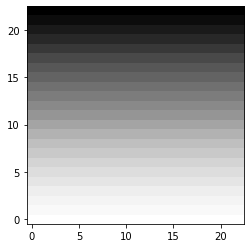

In [10]:
plt.imshow(np.transpose(rast_bd[:,:,1]), cmap='Greys', origin = "lower")

In [11]:
# Retrieve heights
rast_height = retrieve_heights(rast_bd, cur)

In [12]:
rast_height.shape

(23, 23, 3)

In [13]:
plt.imshow(np.transpose(rast_height[:,:,2]), cmap='Greys', origin = "lower")

In [12]:
rast_height

array([[[2682414.966, 1291158.326,       0.   ],
        [2682414.966, 1291160.326,       0.   ],
        [2682414.966, 1291162.326,       0.   ],
        [2682414.966, 1291164.326,       0.   ],
        [2682414.966, 1291166.326,       0.   ],
        [2682414.966, 1291168.326,       0.   ],
        [2682414.966, 1291170.326,       0.   ],
        [2682414.966, 1291172.326,       0.   ],
        [2682414.966, 1291174.326,       0.   ],
        [2682414.966, 1291176.326,       0.   ],
        [2682414.966, 1291178.326,       0.   ]],

       [[2682416.966, 1291158.326,       0.   ],
        [2682416.966, 1291160.326,       0.   ],
        [2682416.966, 1291162.326,       0.   ],
        [2682416.966, 1291164.326,       0.   ],
        [2682416.966, 1291166.326,       0.   ],
        [2682416.966, 1291168.326,      12.194],
        [2682416.966, 1291170.326,      13.073],
        [2682416.966, 1291172.326,       0.   ],
        [2682416.966, 1291174.326,       0.   ],
        [2682416.9

In [51]:
height_mat = pad_crop_matrix(rast_height[:,:,2], 224, 224, crop=True)

In [52]:
height_mat.shape

(224, 224)

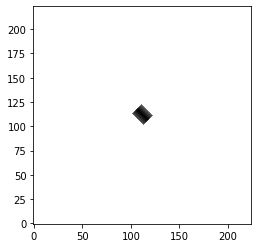

In [53]:
plt.imshow(np.transpose(height_mat), cmap='Greys', origin = "lower")

In [67]:
rast_bd = init_coord_matrix(1, x_diff, y_diff, x_med, y_med)

In [68]:
rast_bd.shape

(23, 23, 3)

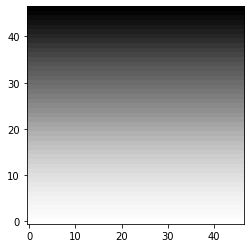

In [18]:
plt.imshow(np.transpose(rast_bd[:,:,1]), cmap='Greys', origin = "lower")

In [19]:
# Retrieve heights
rast_height = retrieve_heights(rast_bd, cur)

In [20]:
rast_height.shape

(47, 47, 3)

In [21]:
plt.imshow(np.transpose(rast_height[:,:,2]), cmap='Greys', origin = "lower")

In [22]:
height_mat = pad_crop_matrix(rast_height[:,:,2], 224, 224, crop=True)

In [23]:
height_mat.shape

(224, 224)

In [24]:
plt.imshow(np.transpose(height_mat), cmap='Greys', origin = "lower")

### Essais avec raster autres (bâti, voirie, etc.)

In [44]:
def retrieve_rast_presence(resolution_m, x_dim, y_dim, x_med, y_med, cursor, table_name):
    """
    Return a numpy array containing the built percentage
    for every pixel of a raster based on the input dimensions
    and resolution
    """
    rast_query = """WITH pix AS (
                    SELECT ST_MakeEnvelope(x_min, y_min, x_max, y_max, 2056) AS geom
                ), intersection AS (
                    SELECT (ST_Dump(ST_Union(ST_Intersection(a.geom, b.geom)))).geom
                    FROM pix a, TABLENAME b
                    WHERE ST_Intersects(a.geom, b.geom)
                ), area AS (
                    SELECT ROUND((ST_Area(geom) / SQUAREAREA)::numeric, 4) AS aire
                    FROM intersection
                )
                SELECT * FROM area"""
    rast_query = rast_query.replace("TABLENAME", str(table_name))
    rast_query = rast_query.replace(
        "SQUAREAREA", str(resolution_m*resolution_m))

    # Create a raster of previously defined size and resolution
    raster = init_coord_matrix(resolution_m, x_dim*resolution_m, y_dim*resolution_m, x_med, y_med)
    print(raster.shape)

    for i in range(1, raster.shape[0]-1):
        for j in range(1, raster.shape[0]-1):

            xmin, ymin = raster[i-1, j-1, :2]
            xmax, ymax = raster[i+1, j+1, :2]

            sql_q = rast_query
            sql_q = sql_q.replace("x_min", str(xmin + (resolution_m/2)))
            sql_q = sql_q.replace("y_min", str(ymin + (resolution_m/2)))
            sql_q = sql_q.replace("x_max", str(xmax - (resolution_m/2)))
            sql_q = sql_q.replace("y_max", str(ymax - (resolution_m/2)))

            cursor.execute(sql_q)
            if cursor.statusmessage != 'SELECT 0':
                raster[i, j, 2] = cursor.fetchone()[0]

    raster = raster[1:x_dim+1, 1:y_dim+1, 2]
    return raster

In [75]:
init_coord_matrix(1, 224, 224, x_med, y_med).shape

(225, 225, 3)

In [73]:
bdg_around = retrieve_rast_presence(1, 224, 224, x_med, y_med, cur, "bdg_zone")

(225, 225, 3)


(224, 224)

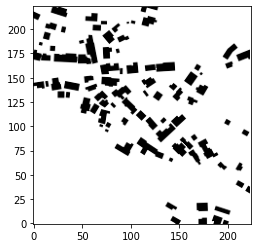

In [55]:
plt.imshow(np.transpose(bdg_around), cmap='Greys', origin = "lower")
bdg_around.shape

In [74]:
road_around = retrieve_rast_presence(1, 224, 224, x_med, y_med, cur, "hway_poly_zone")

(225, 225, 3)


(224, 224)

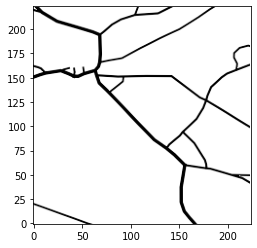

In [59]:
plt.imshow(np.transpose(road_around), cmap='Greys', origin = "lower")
road_around.shape

In [60]:
test = np.array(height_mat, bdg_around, road_around)

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [70]:
test = np.zeros((224,224,3))
test[:,:,0] = height_mat[:]
test[:,:,1] = bdg_around
test[:,:,2] = road_around

In [71]:
test[112, 112, :]

array([15.529,  1.   ,  0.   ])

In [66]:
print(test)

[224 224   3]


In [67]:
print(height_mat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
i=539
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
fig.suptitle("Three channels of a final image", y=0.67, fontsize= 20)
axes[0].imshow(np.transpose(test[:,:,0]), cmap='Greys', origin = "lower")
axes[0].set_title('Building shape (height) (1px = 1m²)')
axes[1].imshow(np.transpose(test[:,:,1]), cmap='Greys', origin = "lower")
axes[1].set_title('Built-up surroundings (1px = 1m²)')
axes[2].imshow(np.transpose(test[:,:,2]), cmap='Greys', origin = "lower")
axes[2].set_title('Road network surroundings (1px = 1m²)') 


# fig.savefig('test.png', bbox_inches='tight', dpi=600)

plt.show()